In [1]:
import pandas as pd
import numpy as np
import elapid
from elapid import MaxentModel
import xarray as xr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_score
import elapid
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score
from sklearn import metrics



In [2]:
data_filepath = '/cluster/home/maikents/coral-mapping/processed_data/df_ready_for_training.parquet'
df = pd.read_parquet(data_filepath)

In [3]:
print(df.columns)

Index(['x', 'y', 'bottom_statistical_northness_features',
       'bottom_statistical_eastness_features', 'current_aspect_angle',
       'bottom_salinity_features_mean', 'bottom_current_features_mean',
       'bottom_temperature_features_10th_percentile', 'label',
       'aspect_cos_clipped', 'aspect_sin_clipped',
       'bathymetry_32N_Clip_sample_clipped', 'broad_BPI_std_clipped',
       'fine_BPI_std_clipped', 'slope_clipped'],
      dtype='object')


In [4]:
#Assuming you have your grid coordinates (xc, yc) and features for each point on the grid (e.g., from SINMOD or other sources)
# You should create a DataFrame with the same features as in your training data (but no label, x, or y)

X_grid = df.drop(columns=['label', 'x', 'y'])

In [5]:
absence_df = df[df['label'] == 0]
downsampled_absences = absence_df.sample(n=2000, random_state=42)

presence_df = df[df['label'] == 1]

In [6]:
balanced_df = pd.concat([downsampled_absences, presence_df])
print(balanced_df.columns)

Index(['x', 'y', 'bottom_statistical_northness_features',
       'bottom_statistical_eastness_features', 'current_aspect_angle',
       'bottom_salinity_features_mean', 'bottom_current_features_mean',
       'bottom_temperature_features_10th_percentile', 'label',
       'aspect_cos_clipped', 'aspect_sin_clipped',
       'bathymetry_32N_Clip_sample_clipped', 'broad_BPI_std_clipped',
       'fine_BPI_std_clipped', 'slope_clipped'],
      dtype='object')


In [7]:
#Define features and labels
X = balanced_df.drop(columns=['label', 'x', 'y'])  #Drop label and coordinates
y = balanced_df['label']

In [8]:
#Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
import elapid

#Define the model and parameter grid
model = elapid.MaxentModel()
param_grid = {
    'beta_multiplier': [0.5, 1.0, 2.0, 4.0],
    'beta_hinge': [0.5, 1.0, 2.0],
    'beta_threshold': [0.5, 1.0, 2.0]
}

#Perform Grid Search CV
cv_model = GridSearchCV(model, param_grid, scoring='roc_auc', cv=10)

cv_model.fit(X_train, y_train)
scoring={'F1': custom_f1, 'BalancedAcc': custom_balanced_accuracy}
#Evaluate the best model on the test set
best_model = cv_model.best_estimator_
y_test_pred = best_model.predict(X_test)
auc_score = roc_auc_score(y_test, y_test_pred)
print(f"Test AUC: {auc_score:.3f}")

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, balanced_accuracy_score
import elapid

# Define the model and parameter grid
model = elapid.MaxentModel()
param_grid = {
    'beta_multiplier': [0.5, 1.0, 2.0, 4.0],
    'beta_hinge': [0.5, 1.0, 2.0],
    'beta_threshold': [0.5, 1.0, 2.0]
}

# Perform Grid Search CV
cv_model = GridSearchCV(
    model, param_grid, 
    scoring={
        'F1': make_scorer(f1_score), 
        'ROC': make_scorer(roc_auc_score, needs_proba=True), 
        'BalancedAcc': make_scorer(balanced_accuracy_score), 
        'Precision': make_scorer(precision_score), 
        'Recall': make_scorer(recall_score)
    }, 
    refit='ROC',  # Use ROC AUC to select the best model
    cv=10
)
cv_model.fit(X_train, y_train)

# Evaluate the best model on the test set
best_model = cv_model.best_estimator_

y_test_pred = best_model.predict_proba(X_test)[:, 1]
y_test_pred_labels = (y_test_pred > 0.5).astype(int)

auc_score = roc_auc_score(y_test, y_test_pred)
balanced_acc = balanced_accuracy_score(y_test, y_test_pred_labels)
f1 = f1_score(y_test, y_test_pred_labels)
precision = precision_score(y_test, y_test_pred_labels)
recall = recall_score(y_test, y_test_pred_labels)

# Print evaluation results
print(f"Test AUC: {auc_score:.3f}")
print(f"Test balanced accuracy: {balanced_acc:.3f}")
print(f"Test F1 score: {f1:.3f}")
print(f"Test recall: {recall:.3f}")
print(f"Test precision: {precision:.3f}")

/cluster/home/maikents/PyEnvCoralMapping/lib/python3.12/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(
/cluster/home/maikents/PyEnvCoralMapping/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:1000: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/cluster/home/maikents/PyEnvCoralMapping/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 139, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/cluster/home/maikents/PyEnvCoralMapping/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 371, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/cluster/home

Test AUC: 0.952
Test balanced accuracy: 0.825
Test F1 score: 0.758
Test recall: 0.704
Test precision: 0.820


In [61]:
model = elapid.MaxentModel()

cv_model = GridSearchCV(
    model, param_grid, 
    scoring={
        'F1': make_scorer(f1_score), 
        'ROC': make_scorer(roc_auc_score), 
        'BalancedAcc': make_scorer(balanced_accuracy_score), 
        'Precision': make_scorer(precision_score), 
        'Recall': make_scorer(recall_score)
    }, 
    refit='ROC',
    cv=10,
    return_train_score=True
)

In [ ]:
cv_model.fit(X_train, y_train)
train_loss = 1 - cv_model.cv_results_['mean_train_ROC']
val_loss = 1 - cv_model.cv_results_['mean_test_ROC']


In [ ]:
cv_model.fit(X_train, y_train)
train_loss = 1 - cv_model.cv_results_['mean_train_ROC']
val_loss = 1 - cv_model.cv_results_['mean_test_ROC']

In [10]:
best_model = cv_model.best_estimator_

In [12]:
print(X_grid.shape)

(100128072, 12)


In [14]:
import numpy as np
chunk_size = 2000
num_chunks = int(np.ceil(len(X_grid) / chunk_size))  

predicted_probabilities_list = []

for i in range(num_chunks):
    start = i * chunk_size
    end = min((i + 1) * chunk_size, len(X_grid))  
    X_chunk = X_grid.iloc[start:end]
    
    chunk_probabilities = best_model.predict_proba(X_chunk)[:, 1]
    
    predicted_probabilities_list.append(chunk_probabilities)

predicted_probabilities = np.concatenate(predicted_probabilities_list)




In [17]:
print(df.columns)

Index(['x', 'y', 'bottom_statistical_northness_features',
       'bottom_statistical_eastness_features', 'current_aspect_angle',
       'bottom_salinity_features_mean', 'bottom_current_features_mean',
       'bottom_temperature_features_10th_percentile', 'label',
       'aspect_cos_clipped', 'aspect_sin_clipped',
       'bathymetry_32N_Clip_sample_clipped', 'broad_BPI_std_clipped',
       'fine_BPI_std_clipped', 'slope_clipped'],
      dtype='object')


In [18]:
x = df['x']
y = df['y']

In [21]:
import matplotlib.pyplot as plt
import numpy as np

In [30]:
selected_rows = df[df['label'] == 1]

# Get the 'x' and 'y' values where label is 1
coral_x = selected_rows['x'].values
coral_y = selected_rows['y'].values


In [32]:
print(len(predicted_probabilities))

100128072


In [31]:
np.save('/cluster/projects/itk-SINMOD/coral-mapping/data/predicted_probabilities.npy', predicted_probabilities)


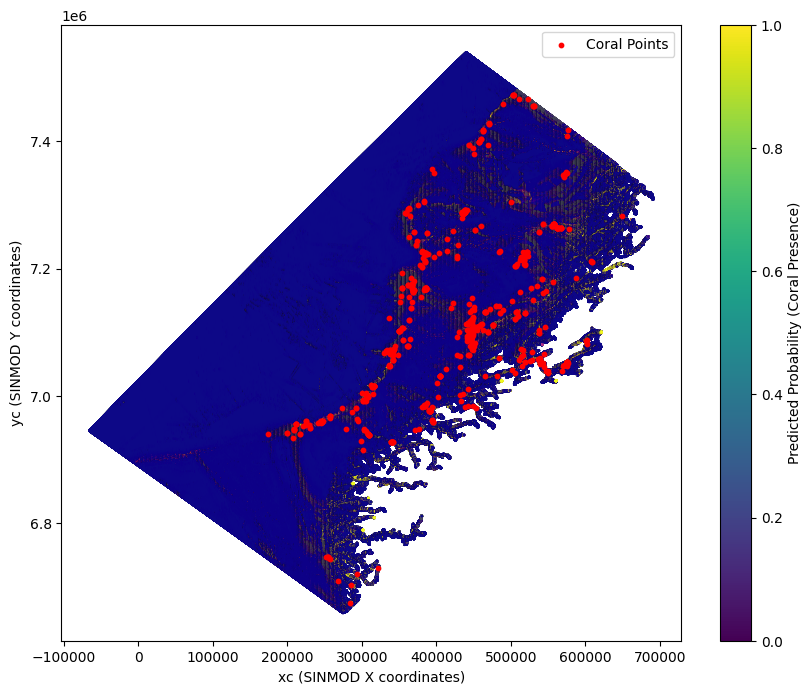

In [29]:
plt.figure(figsize=(10, 8))

# Plot the predicted probabilities for each (x, y) pair
plt.scatter(x, y, c=predicted_probabilities, cmap='plasma', s=1, marker='o')

# Overlay coral presence points in red
plt.scatter(coral_x, coral_y, color='red', label='Coral Points', s=10)

# Add colorbar, labels, and title
plt.colorbar(label='Predicted Probability (Coral Presence)')
plt.xlabel("xc (SINMOD X coordinates)")
plt.ylabel("yc (SINMOD Y coordinates)")
plt.legend()

plt.show()

In [11]:

#Evaluate the best model on the train set
best_model = cv_model.best_estimator_

#Predict probabilities and labels
y_train_pred = best_model.predict_proba(X_train)[:, 1]
y_train_pred_labels = (y_train_pred > 0.5).astype(int)

# Compute metrics on the test set
test_metrics = {
    'AUC': roc_auc_score(y_train, y_train_pred),
    'Balanced Accuracy': balanced_accuracy_score(y_train, y_train_pred_labels),
    'F1 Score': f1_score(y_train, y_train_pred_labels),
    'Precision': precision_score(y_train, y_train_pred_labels),
    'Recall': recall_score(y_train, y_train_pred_labels)
}

# Print results
for metric_name, score in test_metrics.items():
    print(f"Train {metric_name}: {score:.3f}")


Train AUC: 0.981
Train Balanced Accuracy: 0.889
Train F1 Score: 0.856
Train Precision: 0.910
Train Recall: 0.807


In [15]:
def jackknife_test(model, X_train, y_train, X_test, y_test):
    n_features = X_train.shape[1]
    
    auc_scores_individual_features = {}
    auc_scores_leave_one_out = {}

    #Train and evaluate using each feature individually
    for i in range(n_features):
        X_train_single = X_train.iloc[:, i].values.reshape(-1, 1)
        X_test_single = X_test.iloc[:, i].values.reshape(-1, 1)

        model.fit(X_train_single, y_train)

        y_pred_single = model.predict(X_test_single)
        auc_single = roc_auc_score(y_test, y_pred_single)
        auc_scores_individual_features[X_train.columns[i]] = auc_single
    
    #Perform leave-one-out jackknife test
    for i in range(n_features):
        X_train_loo = X_train.drop(X_train.columns[i], axis=1)
        X_test_loo = X_test.drop(X_test.columns[i], axis=1)

        model.fit(X_train_loo, y_train)

        y_pred_loo = model.predict(X_test_loo)
        auc_loo = roc_auc_score(y_test, y_pred_loo)
        auc_scores_leave_one_out[X_train.columns[i]] = auc_loo
    
    #Evaluate the full model
    model.fit(X_train, y_train)
    y_pred_full = model.predict(X_test)
    full_auc = roc_auc_score(y_test, y_pred_full)

    return full_auc, auc_scores_individual_features, auc_scores_leave_one_out

best_model = cv_model.best_estimator_

full_auc, auc_scores_individual_features, auc_scores_leave_one_out = jackknife_test(best_model, X_train, y_train, X_test, y_test)

print(f"Full AUC score = {full_auc:.3f}")


for feature, auc in auc_scores_leave_one_out.items():
    print(f"{feature} dropped: AUC = {auc:.3f}")


for feature, auc in auc_scores_individual_features.items():
    print(f"{feature} only: AUC = {auc:.3f}")

Full AUC score = 0.953
bottom_statistical_northness_features dropped: AUC = 0.956
bottom_statistical_eastness_features dropped: AUC = 0.947
current_aspect_angle dropped: AUC = 0.952
bottom_salinity_features_mean dropped: AUC = 0.953
bottom_current_features_mean dropped: AUC = 0.947
bottom_temperature_features_10th_percentile dropped: AUC = 0.951
aspect_cos_clipped dropped: AUC = 0.949
aspect_sin_clipped dropped: AUC = 0.952
bathymetry_32N_Clip_sample_clipped dropped: AUC = 0.947
broad_BPI_std_clipped dropped: AUC = 0.962
fine_BPI_std_clipped dropped: AUC = 0.957
slope_clipped dropped: AUC = 0.951
bottom_statistical_northness_features only: AUC = 0.834
bottom_statistical_eastness_features only: AUC = 0.856
current_aspect_angle only: AUC = 0.510
bottom_salinity_features_mean only: AUC = 0.724
bottom_current_features_mean only: AUC = 0.614
bottom_temperature_features_10th_percentile only: AUC = 0.796
aspect_cos_clipped only: AUC = 0.644
aspect_sin_clipped only: AUC = 0.519
bathymetry_32N_

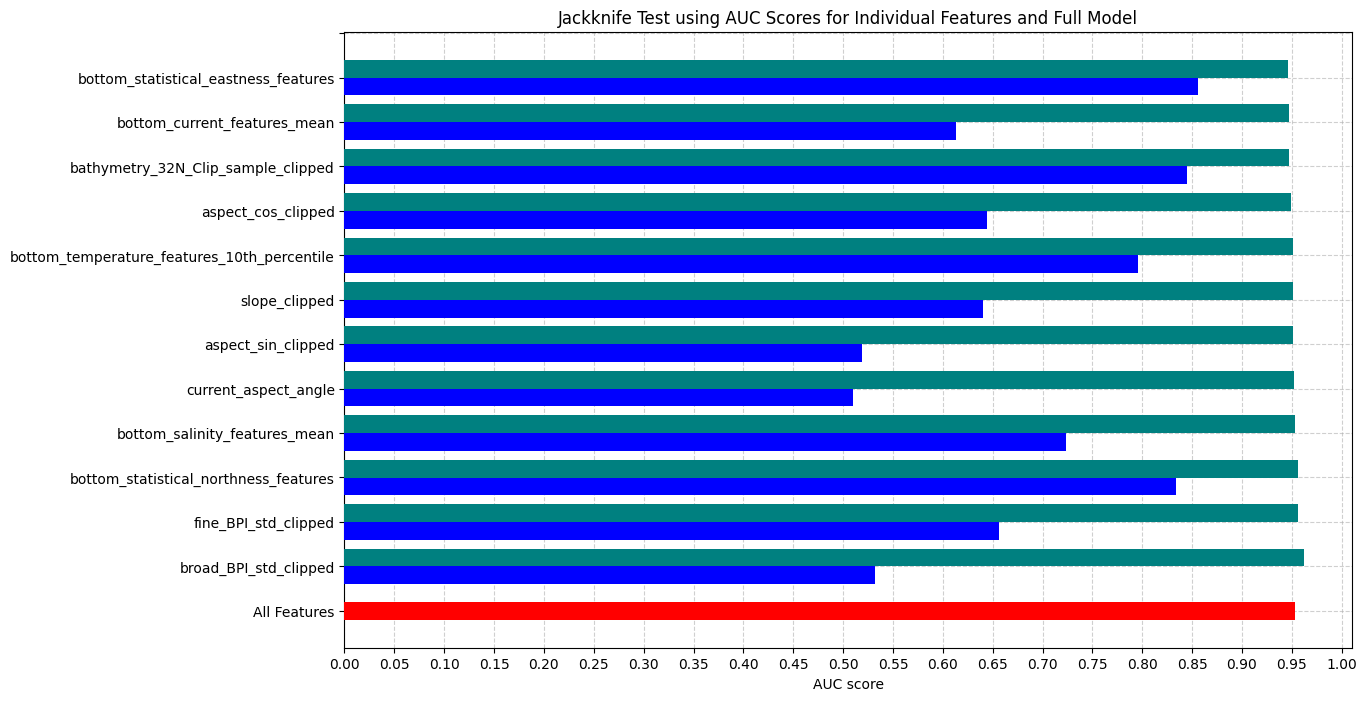

In [37]:
import matplotlib.pyplot as plt

sorted_features = sorted(auc_scores_leave_one_out.items(), key=lambda x: x[1], reverse=True)
features = [feature for feature, _ in sorted_features]
auc_scores_leave_one_out_sorted = [auc_scores_leave_one_out[feature] for feature in features]
auc_scores_individual_features_sorted = [auc_scores_individual_features[feature] for feature in features]


fig, ax = plt.subplots(figsize=(13, 8))

y_pos = np.arange(len(features) + 1) 

ax.barh(y_pos[0], full_auc, color='red', align='center', height=0.4, zorder=3) 
for i, feature in enumerate(features):
    ax.barh(y_pos[i+1] - 0.2, auc_scores_individual_features_sorted[i], color='blue', align='center', height=0.4, zorder=3)  # Blue bar
    ax.barh(y_pos[i+1] + 0.2, auc_scores_leave_one_out_sorted[i], color='teal', align='center', height=0.4, zorder=3)   # Teal bar


ax.set_xlabel('AUC score')
ax.set_title('Jackknife Test using AUC Scores for Individual Features and Full Model')

ax.set_yticks(y_pos)
ax.set_yticklabels(['All Features'] + features) 
ax.xaxis.set_major_locator(plt.MultipleLocator(0.05)) 
ax.yaxis.set_major_locator(plt.MultipleLocator(1))  
ax.grid(True, linestyle='--', alpha=0.6, zorder=0)

# Display the plot
handles, labels = ax.get_legend_handles_labels()
#ax.legend(dict(zip(labels, handles)).values(), dict(zip(labels, handles)).keys())

plt.show()
